<a href="https://colab.research.google.com/github/srikrish2812/pytorch_practice/blob/main/torch_1_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Workflow:

1. Prepare the data and load
2. Build the model
3. Fit/Train the model
4. Making the predictions and evaluating the model
5. Saving and loading the model

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.5.1+cu121'

## Preparing Data and Loading
- Excel/CSV sheets
- Images
- Videos
- Audio
- DNA
- Text

**We need to transform the data into a numerical representation**

1. We will simulate the data using linear regression formula

In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X  = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Splitting data into train and test sets

In [4]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test)

(40, 10)

## Visualize the Data


In [5]:
def plot_predictions(train_data=X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions=None):
    plt.figure(figsize=(9,7))
    # plot the training data
    plt.scatter(train_data, train_labels, c="b",s=4, label="Training data")

    # plot the testing data
    plt.scatter(test_data, test_labels, c="g",s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions,c="r", s=4, label="Predictions")
    plt.legend(prop={"size":14})

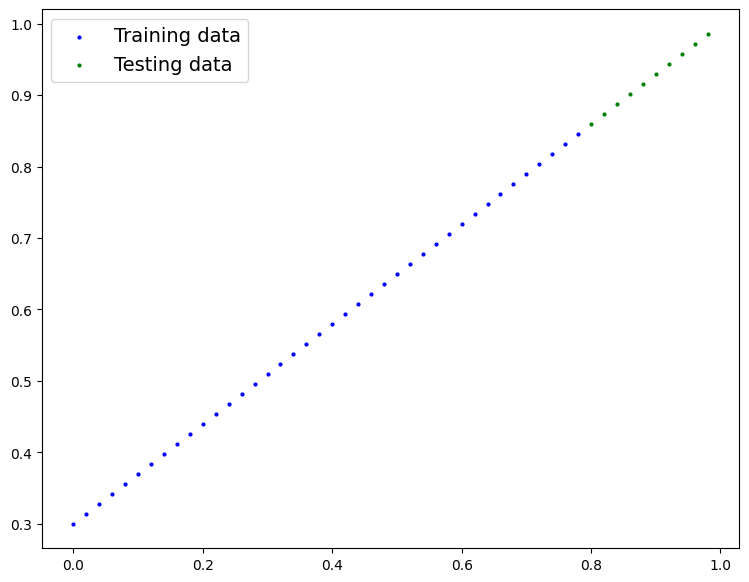

In [6]:
plot_predictions()

## Build the model

In [7]:
class LinearRegressionModel(nn.Module):
    """
    Almost every pytorch model subclasses nn.Module
    """
    def __init__(self):
        super().__init__() # inherits attributes and methods from nn.Module
        self.weights = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float32))

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights*x + self.bias


### Pytorch model building essentials

- torch.nn: contains the components to build computational graphs. A neural network is a directed acyclic graph
- torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
- torch.nn.Module: The base class for all neural network modules, if you subclass it you should overwrite forward()
- torch.optim: diffrent types of optimization algorithms for gradient descent

## Check the model contents

In [8]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
print(list(model_0.parameters()))
model_0.state_dict()

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making the prediction using `torch.inference_mode()`

- When we pass data thorugh our model it's going to run it trhough the `forward()` method
https://pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html

In [9]:
model_0(X_test)

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [10]:
# make predictions with model
# with torch.inference removes the gradient tracking as
# it is not required while getting the predictions on the test set since we are not training. There is no need to track gradients
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

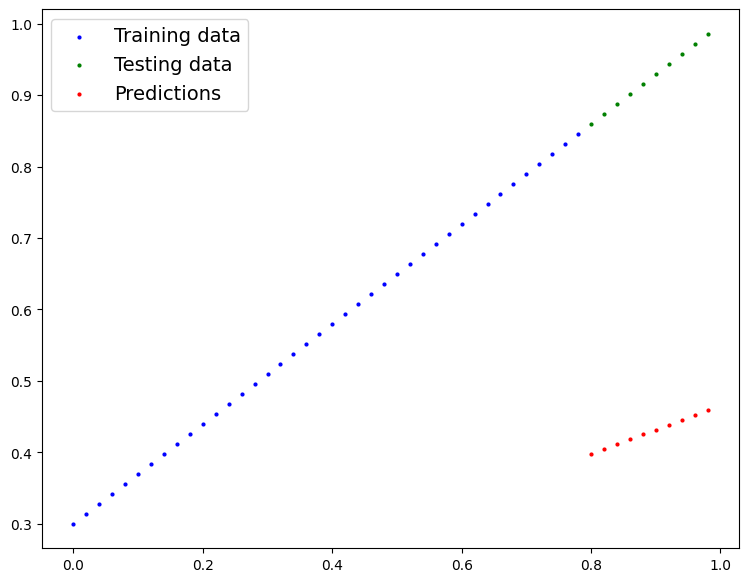

In [11]:
plot_predictions(predictions=y_preds)

## Training Intuition

1. The whole idea of training is for a model to move from some unknown parameters to some known parameters.
2. Or in other words from a poor representation of data to a better represenation
3. A loss function can be used to quantify how wrong a model's predictions are wrt the ground truth values
4. Optimizers take into account the loss of a model and adjusts the model's parameters in the direction of decreasing loss

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
# Setup a loss function
loss_fn = nn.L1Loss()

# setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01)

## Building a training loop and testing loop in PyTorch

0. Loop through the data
1. Forward pass: moving through the model's `forward()` to get the predictions on data
2. Calculate the loss(compare forward pass to ground truth labels)
3. Optimizer zero grad
4. Back Propagation - move backwards through the network to calculate the gradients of loss wrt each parameter
5. Adjust the parameter to reduce the loss iteratively. Use optimizer step

In [14]:
epochs = 200
torch.manual_seed(42)

epoch_count = []
loss_value = []
test_loss_values = []
# 0. looping data
for epoch in range(epochs):
    # set the model to traiing mode
    model_0.train() # train() mode sets all params that requires gradients to require_gradients=True

    # 1. Forward Pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    #print("Loss:",loss)

    # 3. Zero the optimizer gradients
    optimizer.zero_grad()

    # 4. Perform back propagation
    loss.backward()

    # 5. Step the optimizer
    optimizer.step() # how the optimizer changes will accumulate through the loop so we have to zero them in step 3

    # Testing
    model_0.eval() # turns off gradient tracking
    with torch.inference_mode(): # this mode turns off gradient tracking and some more settings
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch%10==0:
        epoch_count.append(epoch)
        loss_value.append(np.array(torch.tensor(loss).cpu().numpy()))
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    print(model_0.state_dict())


<ipython-input-14-a51a73334ef2>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_value.append(np.array(torch.tensor(loss).cpu().numpy()))


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
OrderedDict([('weights', tensor([0.3640])), ('bias', tensor([0.1988]))])
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
OrderedDict([('weights', tensor([0.3718])), ('bias', tensor([0.2188]))])
OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.2288]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
OrderedDict([('weights', tensor([0.3835])), ('bias', tenso

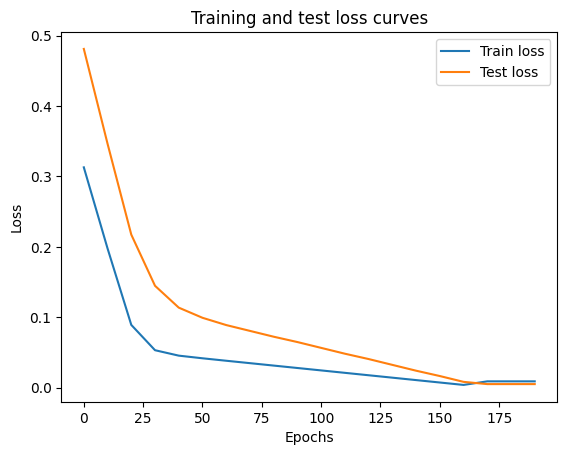

In [15]:
plt.plot(epoch_count, loss_value,label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [16]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

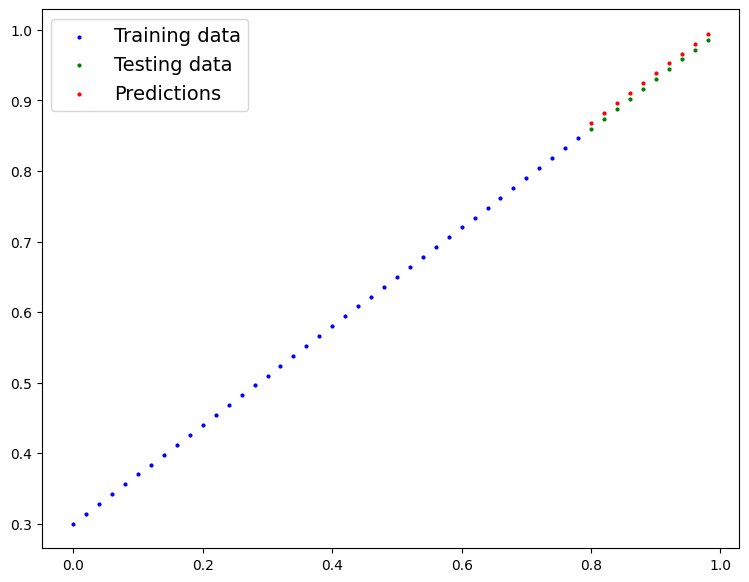

In [17]:
plot_predictions(predictions=y_preds_new)

## Saving the Model

1. `torch.save()`: allows you to save a PyTorch object in Python's pickle format
2. `torch.load()`: allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()`: allows to load a model's saved state dictionary

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [18]:
from pathlib import Path

# create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# save the state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_0.pth


## Load the Model

Since we save the model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved state_dict() into that

`torch.nn.Module.load_state_dict()`: allows to load a model's saved state dictionary

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [20]:
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict() of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-20-6817e6066b80>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [21]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [22]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [23]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

print(y_preds)
y_preds==loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together

In [24]:
# import modules
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

torch.__version__

'2.5.1+cu121'

Create device agnostic code

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device = {device}")

Using device = cpu


## 1. Data

In [55]:
# create some data using linear regression formula of y=weight*X + bias
weight = 0.7
bias = 0.3

# create range of values
start = 0
end =1
step=0.02

# create X and y
X = torch.arange(start, end,step).unsqueeze(dim=1)
y = weight*X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [27]:
# split data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

### Visualize the data

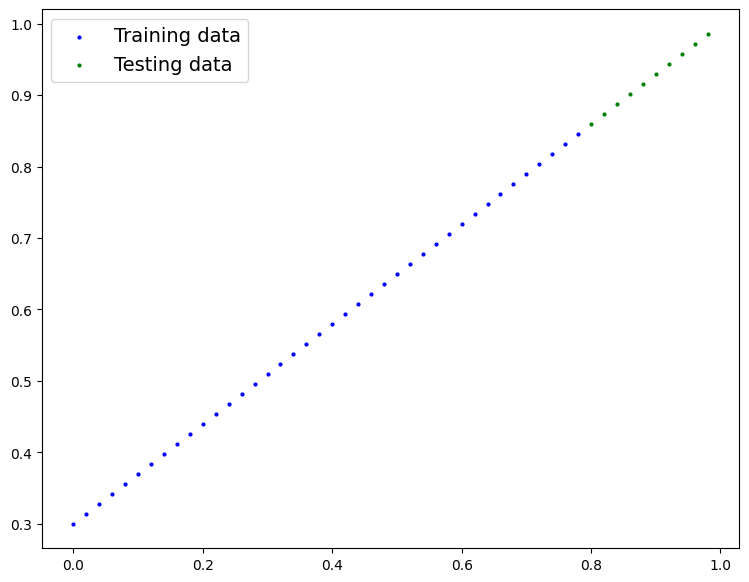

In [28]:
# PLot the data

plot_predictions(X_train, y_train, X_test, y_test)

## 2. Build the Model

[nn.Linear(in_features, out_features)](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

in_features: size of each input sample
out_features: size of each output sample

In [29]:
 # subclass nn.Module class
class Linear(nn.Module):
    def __init__(self):
        """
        create linear layer using nn.Linear
        nn.Linear() is used for creating model parameters
        nn.Linear(x) performs x.W + b
        """
        super().__init__()
        self.linear = nn.Linear(in_features=1,
                                out_features=1,
                                bias=True)
    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.linear(x)

torch.manual_seed(42)
model_1 = Linear()
print(model_1.state_dict())
print(model_1)

OrderedDict([('linear.weight', tensor([[0.7645]])), ('linear.bias', tensor([0.8300]))])
Linear(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [30]:
# check which device the model is on
print(next(model_1.parameters()).device)

# move to the gpu
model_1.to(device)
print(next(model_1.parameters()).device)

cpu
cpu


## 3. Training

For training we need

- Loss function
- Optimizer
- Training Loop
- Testing Loop

In [31]:
# define loss function
loss_fn = nn.L1Loss()

# define optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),lr=0.01)

In [32]:
# training loop
torch.manual_seed(42)

epochs=200
# Put data on the target device

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # set to train mode
    model_1.train()

    # 1. Forwards pass
    y_pred = model_1(X_train)

    # 2. calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. zero the optimizer gradients
    optimizer.zero_grad()

    # 4. Back propagate the loss
    loss.backward()

    # 5. accumulate the gradients
    optimizer.step()

    """
    Testing loop
    """
    # set to eval() mode
    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss : {test_loss}")





Epoch: 0 | Loss: 0.5551779866218567 | Test Loss : 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test Loss : 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss : 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test Loss : 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test Loss : 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test Loss : 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test Loss : 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss : 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test Loss : 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss : 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test Loss : 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test Loss : 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss : 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss : 0.

In [33]:
model_1.state_dict()

OrderedDict([('linear.weight', tensor([[0.6968]])),
             ('linear.bias', tensor([0.3025]))])

## 4. Make predictions and Visualize

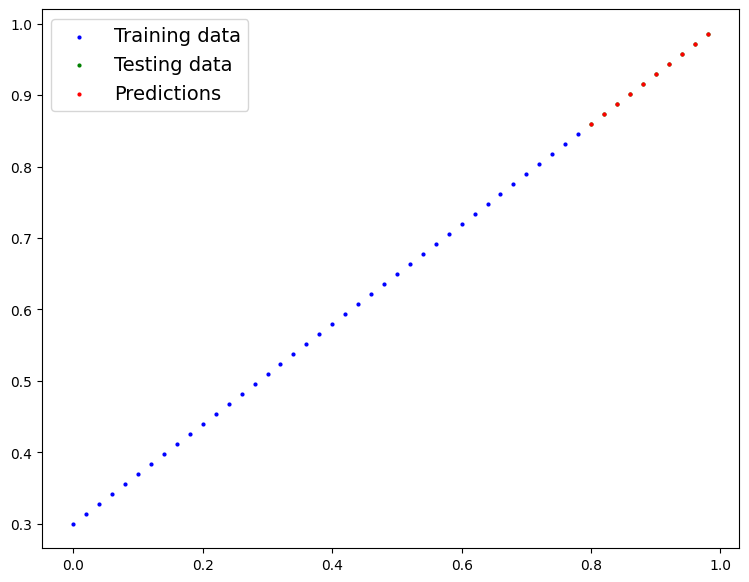

In [34]:
model_1.eval()
with torch.inference_mode():
    y_test_preds = model_1(X_test)

plot_predictions(predictions=y_test_preds.cpu()) # move the preds to cpu

## 5. Saving and Loading model

In [35]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_1.pth


In [36]:
loaded_model_1 = Linear()

loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_1.state_dict()

<ipython-input-36-426c8724e39b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


OrderedDict([('linear.weight', tensor([[0.6968]])),
             ('linear.bias', tensor([0.3025]))])

In [37]:
next(loaded_model_1.parameters()).device

loaded_model_1.to(device)
next(loaded_model_1.parameters()).device

device(type='cpu')

In [38]:
loaded_model_1.state_dict()

OrderedDict([('linear.weight', tensor([[0.6968]])),
             ('linear.bias', tensor([0.3025]))])

In [39]:
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
loaded_model_1_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

# Exercises:

## 1. Create a straight line dataset using the linear regression formula (weight * X + bias).
- Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
- Split the data into 80% training, 20% testing.
- Plot the training and testing data so it becomes visual.


In [57]:
weight=0.3
bias = 0.9

start = 0
end =1
step =0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

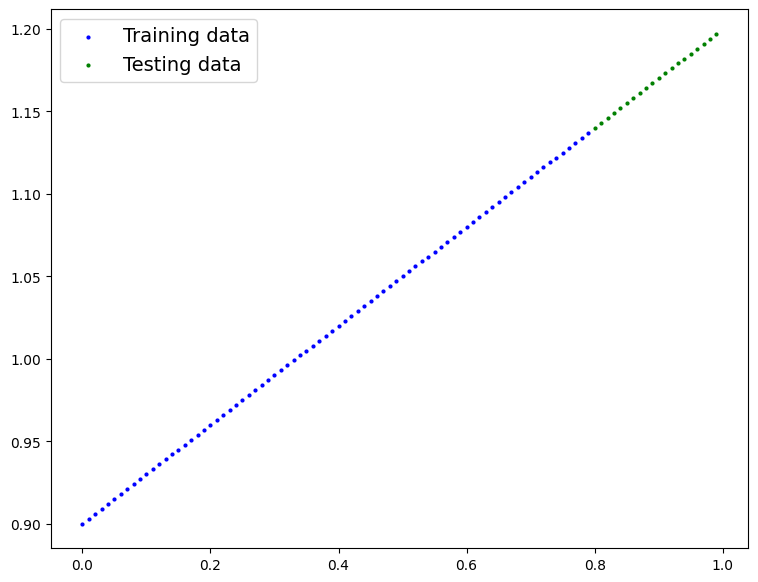

In [58]:
plot_predictions(X_train, y_train, X_test, y_test)

## 2. Build a PyTorch model by subclassing nn.Module.
- Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
- Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
- Once you've constructed the model, make an instance of it and check its state_dict().

In [62]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(
            in_features=1,
            out_features=1,
            bias=True
        )

    def forward(self, x: torch.Tensor)->torch.Tensor:
        return self.linear(x)
torch.manual_seed(42)
lin_model = LinearModel()
lin_model.state_dict()

OrderedDict([('linear.weight', tensor([[0.7645]])),
             ('linear.bias', tensor([0.8300]))])

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lin_model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

## 3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.

- Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
- Write a training loop to perform the appropriate training steps for 300 epochs.
- The training loop should test the model on the test dataset every 20 epochs.

In [64]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=lin_model.parameters(),
                            lr=0.01)

epochs = 300

for epoch in range(epochs):
    lin_model.train()

    # 1. forward pass
    y_preds = lin_model(X_train)

    # 2. compute loss
    loss =loss_fn(y_preds, y_train)

    # 3. zero the optimizer gradients
    optimizer.zero_grad()

    # 4. back propagate the loss
    loss.backward()

    # 5. step optimizer gradients
    optimizer.step()

    ## testing loop
    if epoch%20==0:
        lin_model.eval()
        with torch.inference_mode():
            test_preds = lin_model(X_test)
            test_loss = loss_fn(test_preds, y_test)
        print(f"Epoch: {epoch} | Loss : {loss} | Test Loss: {test_loss}")




Epoch: 0 | Loss : 0.12756133079528809 | Test Loss: 0.33650320768356323
Epoch: 20 | Loss : 0.08187223970890045 | Test Loss: 0.2184026539325714
Epoch: 40 | Loss : 0.07207288593053818 | Test Loss: 0.17458662390708923
Epoch: 60 | Loss : 0.06507987529039383 | Test Loss: 0.15310418605804443
Epoch: 80 | Loss : 0.05822876840829849 | Test Loss: 0.1367770880460739
Epoch: 100 | Loss : 0.05137667804956436 | Test Loss: 0.12079393863677979
Epoch: 120 | Loss : 0.044525571167469025 | Test Loss: 0.10446684062480927
Epoch: 140 | Loss : 0.037674423307180405 | Test Loss: 0.08813951164484024
Epoch: 160 | Loss : 0.03082224354147911 | Test Loss: 0.0721558928489685
Epoch: 180 | Loss : 0.02397105097770691 | Test Loss: 0.055828340351581573
Epoch: 200 | Loss : 0.01711984910070896 | Test Loss: 0.03950077295303345
Epoch: 220 | Loss : 0.010267667472362518 | Test Loss: 0.02351721003651619
Epoch: 240 | Loss : 0.0034169009886682034 | Test Loss: 0.007191836833953857
Epoch: 260 | Loss : 0.007878491654992104 | Test Loss:

## 4. Make predictions with the trained model on the test data.

- Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [65]:
lin_model.eval()
with torch.inference_mode():
    y_test_preds = lin_model(X_test)
y_test_preds

tensor([[1.1333],
        [1.1363],
        [1.1393],
        [1.1423],
        [1.1454],
        [1.1484],
        [1.1514],
        [1.1545],
        [1.1575],
        [1.1605],
        [1.1635],
        [1.1666],
        [1.1696],
        [1.1726],
        [1.1757],
        [1.1787],
        [1.1817],
        [1.1847],
        [1.1878],
        [1.1908]])

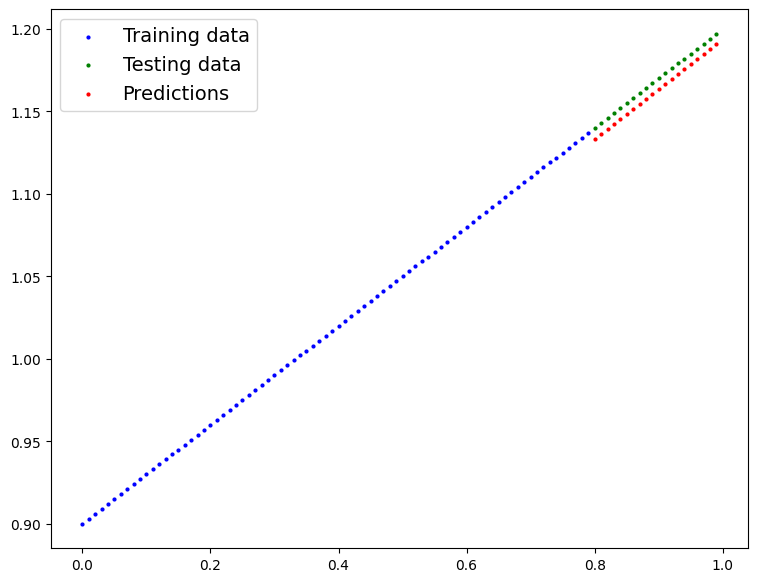

In [68]:
plot_predictions(X_train, y_train,X_test, y_test,predictions=y_test_preds.cpu())

## 5. Save your trained model's state_dict() to file.
- Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
- Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.


In [69]:
NEW_MODEL_NAME = "01_pytorch_exercise.pth"
NEW_MODEL_PATH = MODEL_PATH/NEW_MODEL_NAME
torch.save(lin_model.state_dict(),f=NEW_MODEL_PATH)

In [71]:
load_lin_model = LinearModel()

load_lin_model.load_state_dict(torch.load(f=NEW_MODEL_PATH))

<ipython-input-71-4ce9f606c4fd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_lin_model.load_state_dict(torch.load(f=NEW_MODEL_PATH))


<All keys matched successfully>

In [72]:
load_lin_model_preds = load_lin_model(X_test)
print(load_lin_model_preds==y_test_preds)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


# Workflow completed. Exercises Completed!!